# Imports

In [1]:
import sys; sys.path.append("../..")
from EncoderDecoderShareVAE import EncoderDecoderShareVAE
import NewsVAEArguments
import torch
from transformers.generation_utils import top_k_top_p_filtering
from NewsData import NewsData
import numpy as np
import copy
import torch.nn.functional as F
from trainNewsVAE import load_from_checkpoint
from utils import transfer_batch_to_device
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# from pytorch_lightning import seed_everything; seed_everything(0)

# Check if on server
if torch.cuda.is_available():
    print("Using GPU :-)...")
    device = "cuda"
else:
    print("Warning: using CPU!")
    device = "cpu"
    
# Overwrite some arguments
args = NewsVAEArguments.preprare_parser(jupyter=True, print_settings=False)
args.ddp = False
args.n_gpus = 1

import multiprocessing; print("Number of CPU cores: {}".format(multiprocessing.cpu_count()))

Using GPU :-)...
Number of CPU cores: 12


# Get some validation data to experiment with

In [2]:
# Get data
data = NewsData(args.dataset_name, args.tokenizer_name,
                batch_size=args.batch_size, num_workers=args.num_workers,
                pin_memory=(device=="cuda"), debug=args.debug_data,
                debug_data_len=args.debug_data_len, max_seq_len=args.max_seq_len, device=device)

# Loading pre-trained models (Beta-VAE and MMD-VAE checkpoint)

In [3]:
# Get model architecture
VAE_model = EncoderDecoderShareVAE(args, args.base_checkpoint_name, do_tie_weights=args.do_tie_weights).to(device)

# # Load weights
beta_vae_path = "/home/cbarkhof/code-thesis/NewsVAE/Runs/18NOV-BETA-VAE-run-2020-11-18-12:36:55/checkpoint-best.pth"
mmd_vae_path = "/home/cbarkhof/code-thesis/NewsVAE/Runs/18NOV-MMD-VAE-run-2020-11-18-12:36:55/checkpoint-best.pth"

# Need to make a deepcopy otherwise the weights are assigned to the original VAE_model which leads to confusing results :O
_, _, beta_vae, _, _, _, _ = load_from_checkpoint(copy.deepcopy(VAE_model), path=beta_vae_path)
_, _, mmd_vae, _, _, _, _ = load_from_checkpoint(copy.deepcopy(VAE_model), path=mmd_vae_path)

beta_vae.eval(); mmd_vae.eval(); VAE_model.eval();

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VAE_Decoder_RobertaForCausalLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'VAE_Decoder_Roberta.VAE_Decoder_RobertaModel'> and <class 'transformers.modeling_roberta.RobertaModel'> are not equal. In this case make sure that all encoder weights are correctly initialized. 
The following encoder weights were not tied to the decoder ['roberta/pooler']
Loading VAE_model, optimizer and scheduler from /home/cbarkhof/code-thesis/NewsVAE/Runs/18NOV-BETA-VAE-run-2020-11-18-12:36:55/checkpoint-best.pth
first removing module string from checkpoint
Checkpoint global_step: best, epoch: 18, best_valid_loss: 3.141055178642273
Loading VAE_model, optimizer and scheduler from /home/cbarkhof/code-thesis/NewsVAE/Runs/18NOV-MMD-VAE-run-2020-11-18-12:36:55/checkpoint-best.pth
first removing module string from checkpoint
Checkpoint global_step: best, epoch: 32, best_valid_loss: 2.2885116815567015


In [5]:
def batch_decode(batch_of_samples, tokenizer):    
    return [tokenizer.decode(a.tolist()) for a in batch_of_samples]

def auto_regressive_decode(model, latent_z, tokenizer, args, max_seq_len=32, nucleus_sampling=False, temperature=1.0, top_k=0, top_p=0.9):
    batch_size = latent_z.shape[0]

    # Add <s> and </s>
    generated_so_far = torch.tensor([[data.tokenizer.bos_token_id, data.tokenizer.eos_token_id] for _ in range(batch_size)])
    generated_so_far = generated_so_far.cuda(0)

    for i in range(max_seq_len):        
        # Forward the decoder
        decoder_outs = model.decoder(input_ids=generated_so_far, attention_mask=None,
                                    latent_z=latent_z, labels=None,
                                    add_latent_via_embeddings=args.add_latent_via_embeddings,
                                    add_latent_via_memory=args.add_latent_via_memory,
                                    return_cross_entropy=False, return_predictions=True,
                                    return_exact_match_acc=False)

        if nucleus_sampling:
            # The forward of the decoder already cuts of the prediction for the last token
            logits = decoder_outs["logits"][:, -1, :]

            # Temperature (higher temperature => more likely to sample low probability tokens)
            if temperature != 1.0:
                scores = scores / temperature

            # Top-p/top-k filtering
            next_token_logscores = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)

            # Sample
            probs = F.softmax(next_token_logscores, dim=-1)
            new_preds = torch.multinomial(probs, num_samples=1).squeeze(1)
        else:
            new_preds = decoder_outs['predictions'][:, -1] # argmax predictions

        generated_so_far = torch.cat((generated_so_far[:, :-1], new_preds.unsqueeze(1), generated_so_far[:, -1].unsqueeze(1)), dim=1)
    return generated_so_far

def encode(model, input_batch, deterministic=False):
    encoder_outs = model.encoder(input_ids=input_batch['input_ids'], attention_mask=input_batch['attention_mask'])
    latent_z, _, _ = model.connect_encoder_decoder(encoder_outs.pooler_output, deterministic=deterministic)
    
    return latent_z

def encode_auto_regressive_decode(model, input_batch, tokenizer, args, max_seq_len=64, nucleus_sampling=True):
    with torch.no_grad():
        latent_z = encode(model, input_batch)
        generated = auto_regressive_decode(model, latent_z, tokenizer, args, max_seq_len=max_seq_len, nucleus_sampling=nucleus_sampling)
        generated_text = batch_decode(generated, tokenizer)
        
        return generated_text

# Reconstruct text with different trained models and different sampling

In [6]:
results = {'original': [],
           'argmax': {
               'beta-VAE': [], 
               'MMD-VAE': [], 
               'untrained-VAE': []
           }, 
           'nucleus_sampling': {
               'beta-VAE': [], 
               'MMD-VAE': [], 
               'untrained-VAE': []
           }
          }

max_batches = 5
for batch_i, input_batch in enumerate(data.val_dataloader(shuffle=True)):
    
    input_batch = transfer_batch_to_device(input_batch, 0)
    original_text = batch_decode(input_batch['input_ids'], data.tokenizer)
    results['original'].extend(original_text)
    
    for sampling, sampling_mode in zip([True, False], ['nucleus_sampling', 'argmax']):
        for model, model_name in zip([mmd_vae, beta_vae, VAE_model], ['MMD-VAE', 'beta-VAE', 'untrained-VAE']):
            generated_text = encode_auto_regressive_decode(model, input_batch, data.tokenizer, 
                                                           args, max_seq_len=64, nucleus_sampling=sampling)
            results[sampling_mode][model_name].extend(generated_text)

    if batch_i + 1 == max_batches: break

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)
/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor.

In [7]:
for i in range(len(results['original'])):
    print("*"*40)
    print("SAMPLE", i)
    print("*"*40)
    print("\n-> Original text:\n", results['original'][i], '\n')
    print("-"*40)
    
    for sampling, sampling_mode in zip([True, False], ['nucleus_sampling', 'argmax']):
        print("\n {} -> Untrained VAE:\n".format(sampling_mode.upper()), results[sampling_mode]['untrained-VAE'][i])
        print("\n {} -> Beta VAE:\n".format(sampling_mode.upper()), results[sampling_mode]['beta-VAE'][i])
        print("\n {} -> MMD VAE:\n".format(sampling_mode.upper()), results[sampling_mode]['MMD-VAE'][i], '\n')

****************************************
SAMPLE 0
****************************************

-> Original text:
 <s>(CNN)Seven college-age people, some who came to Panama City Beach, Florida, for spring break, were wounded in a late-night shooting, the Bay County Sheriff's Office said in a press release. Officers met "complete chaos" when they tried to find out what happened not long after midnight</s> 

----------------------------------------

 NUCLEUS_SAMPLING -> Untrained VAE:
 <s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s></s>

 NUCLEUS_SAMPLING -> Beta VAE:
 <s>A new wave of people visiting the Oklahoma state beach after a deadly shooting spree entered the third neighborhood where the gunman -- an 18-year-old suspect -- lived, a report from the state Justice Department said Wednesday. About 60 people checked into a condo at the 6 Seaso

# Sampling

In [5]:
def sample_from_prior(latent_size=768, n_samples=8):
    loc = torch.zeros(latent_size, device='cuda:0')
    scale = torch.ones(latent_size, device='cuda:0')
    prior_dist = torch.distributions.normal.Normal(loc, scale)
    samples = prior_dist.sample((n_samples,))
    return samples
    
def sample_text(model, tokenizer, args, n_samples=8, max_seq_len=64, nucleus_sampling=True):
    with torch.no_grad():
        latent_z = sample_from_prior(model.latent_size, n_samples=n_samples)
        generated = auto_regressive_decode(model, latent_z, tokenizer, args, max_seq_len=max_seq_len, nucleus_sampling=nucleus_sampling)
        generated_text = batch_decode(generated, tokenizer)
        return generated_text

In [6]:
for model, name in zip([mmd_vae, beta_vae], ['MMD-VAE', 'Beta-VAE']):
    print('Samples from:', name)
    gen_text = sample_text(model, data.tokenizer, args, n_samples=20, max_seq_len=64, nucleus_sampling=True)
    for i, t in enumerate(gen_text):
        print(i)
        print(t)
        print()
    print("-"*30)

Samples from: MMD-VAE
0
<s> they of ofilesos and and ofigisippers and and smugglers. ofus.s..ania areates on on with ofures and on Tuesday ofs ofis ofs ofs and peoples ofon ofis ofates on Tuesday on Monday.. and ofims forors. but</s></s></s>

1
<s>travel ��……!”(s , –, a!…’,…!!,’…,!,, again!”!!!….,’.!, – –,, we’t ,,’..</s></s></s>

2
<s> Augustger Meues,, Japanese 72ues, Japan, Mainets, Lockheedgers Lockheed, 80, takesues as Harbor, 7480,,uesuesues asuesues,,54, followsuesuesues, continuesuesuesuesues,72uesues,80, continuesuesuesuesuesuesues</s>

3
<s>By Mark Mark Mark In. Mark Mark In Policy Policy Service. Modern Strategy For For Growth. Mark Mark Mark.. Mark. 2004:.. 10 2013:. 2014 2014 2012. 02:.:. 14 House.:. October.. 12: Inative: Tom Speaker to:. of</s></s></s>

4
<s>Parisinrescresty staff,fcty)tyNewsNews)Newsroom)...tyxcom,...News...:];... Forces(tytyty;;...ises:;;:,:;;.?;;,:;,,:,,;</s></s></s>

5
<s>- profession orvan orHer or or Rafael or or or or or or or of or (/re) of of of

In [8]:
n_samples = 1000
batch_size = 10

prior_samples = sample_from_prior(latent_size=768, n_samples=n_samples)

encoded_samples_beta = []
encoded_samples_mmd = []

with torch.no_grad():
    assert n_samples % batch_size == 0, "n_samples must be exactly divisible by the batch size!"
    max_batches = int(n_samples / batch_size)
    print(max_batches)
    for batch_i, input_batch in enumerate(data.val_dataloader(shuffle=True, batch_size=batch_size)):
        if batch_i % 10 == 0: print("Batch {:2d}/{}".format(batch_i, max_batches), end='\r')

        input_batch = transfer_batch_to_device(input_batch, 0)
        encoded_samples_beta.append(encode(beta_vae, input_batch, deterministic=False))
        encoded_samples_mmd.append(encode(mmd_vae, input_batch, deterministic=False))

        if batch_i + 1 == max_batches: break
        
encoded_samples_beta = torch.cat(encoded_samples_beta)
encoded_samples_mmd = torch.cat(encoded_samples_mmd)

print(prior_samples.shape, encoded_samples_beta.shape, encoded_samples_mmd.shape)

100


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)
/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor.

torch.Size([1000, 768]) torch.Size([1000, 768]) torch.Size([1000, 768])


In [9]:
all_samples = torch.cat((prior_samples, encoded_samples_beta, encoded_samples_mmd))
all_samples_pca = PCA(n_components=50).fit_transform(all_samples.cpu().numpy())
all_samples_tsne_2dim = TSNE(n_components=2, n_iter=500, perplexity=20).fit_transform(all_samples_pca)

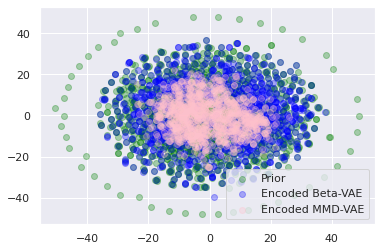

In [10]:
plt.scatter(all_samples_tsne_2dim[:1000, 0], all_samples_tsne_2dim[:1000, 1], label='Prior', alpha=0.3, color='green')
plt.scatter(all_samples_tsne_2dim[1000:2000, 0], all_samples_tsne_2dim[1000:2000, 1], label='Encoded Beta-VAE', alpha=0.3, color='blue')
plt.scatter(all_samples_tsne_2dim[2000:, 0], all_samples_tsne_2dim[2000:, 1], label='Encoded MMD-VAE', alpha=0.3, color='pink')
plt.legend()
plt.show()

# Interpolation

In [9]:
import pandas as pd

def interpolate(z1, z2, steps=10):
    z_step = (z2 - z1) / (steps-1)
    
    interpolated_zs = [z1 + (i * z_step) for i in range(steps)]
    interpolated_zs = torch.stack(interpolated_zs)
    
    return interpolated_zs

for batch_i, input_batch in enumerate(data.val_dataloader(shuffle=True, batch_size=2)):
    
    print("*"*80)
    print("\nINTERPOLATION {}".format(batch_i))
    print("-"*80)

    result = {}
    
    with torch.no_grad():
        input_batch = transfer_batch_to_device(input_batch, 0)
        original_texts = batch_decode(input_batch['input_ids'], data.tokenizer)
        
        print("*"*50)
        print("** SOURCE SENTENCE:")
        print("*"*50)
        print(original_texts[0])
        
        result = {}
        
        for (model, model_name) in zip([mmd_vae, beta_vae], ["mmd_vae", "beta_vae"]):
            latent_z = encode(model, input_batch, deterministic=False)
                
            zs = interpolate(latent_z[0, :], latent_z[1, :])

            generated = auto_regressive_decode(model, zs, data.tokenizer, args, max_seq_len=64, nucleus_sampling=False)
            generated_text = batch_decode(generated, data.tokenizer)

            result[model_name] = generated_text
            
        for i in range(len(generated_text)):
            print("Step {}\n".format(i))
            print("-> MMD-VAE:\t", result['mmd_vae'][i])
            print("-> Beta-VAE:\t", result['beta_vae'][i])
            print('-'*80)
        
        print("*"*50)
        print("** TARGET SENTENCE:")
        print("*"*50)
        print(original_texts[1])

    break

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)
/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor.

********************************************************************************

INTERPOLATION 0
--------------------------------------------------------------------------------
**************************************************
** SOURCE SENTENCE:
**************************************************
<s>Maui, Hawaii (CNN)When she was just 4 years old, Chelsea Elliott went blind in her left eye. Then, two years later, she lost hearing in her right ear. Now 24, Elliott might have been spared years of struggle if her rare eye condition -- known as Coats disease --</s>
Step 0

-> MMD-VAE:	 <s>When she was 4 years old, she lost her left eye in Hawaii. Then, in 2002, Clara Coghlan was 14 years old. Now, her eyesight could never be matched by her rare hearing loss -- when she went blind in 2009. Coghlan, 24, may have lost half of</s></s></s>
-> Beta-VAE:	 <s>When Ben Benoit was just 15 years old, he was diagnosed with a rare form of cancer. But when Benoit was diagnosed with breast cancer in 2